<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [3170]:
%%capture
pip install pyswarms

In [3171]:
%%capture
pip install scipy

In [3172]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [3173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3235]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 15000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 3000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_pso_quarto_cenario'
NOME_ARQUIVO_TEMPO_SEVERIDADE = 'tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '04'

In [3175]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [3176]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [3177]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [3178]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [3179]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [3180]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [3181]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [3182]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [3183]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [3184]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [3185]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [3186]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-11-03 22:39:02,117 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0835
2023-11-03 22:39:02,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08352594484994318, best pos: [148.48872466   1.00143541   0.61421597]


In [3187]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.488724656049
beta: 1.0014354090057516
theta: 0.6142159735370886

Tempo de Convergência para a primeira etapa: 0.009462833404541016 segundos


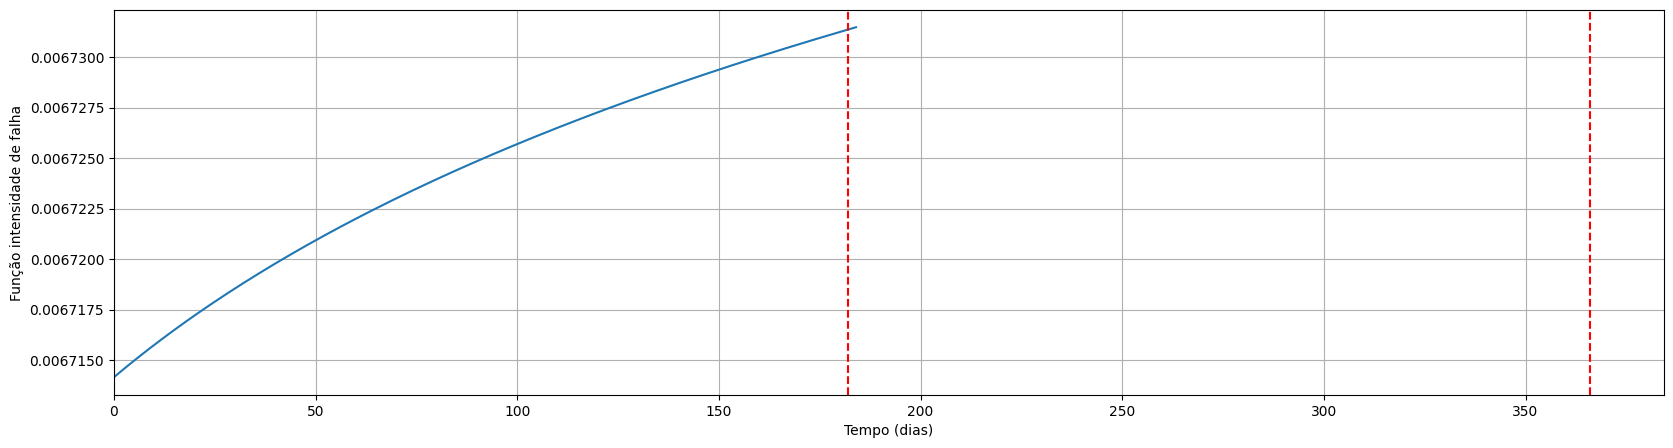

Fator ajuste:  [0.47026631725877077, 0.47026631725877077, 0.47026631725877077, 0.47026631725877077, 0.47026631725877077, 0.27217194149907276, 0.27217194149907276, 0.47026631725877077, 0.27217194149907276, 0.47026631725877077, 0.27217194149907276, 0.47026631725877077, 0.47026631725877077, 0.47026631725877077]


In [3188]:
lamb = 149.14151188589648
beta = 1.0024136102117993
theta = 0.6353808841179692

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [3189]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [3190]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-11-03 22:39:03,663 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=1.92e+3



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 88, 161, 196, 250, 309, 428, 547, 586, 668, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.5892927993409528, 1.079209990356948, 1.3143152471279194, 1.6773705678984707, 2.074123623146342, 2.8751821542500435, 3.676760791177756, 3.939540586386414, 4.492201220430485, 4.781963329750432, 4.910056241965936]
Custo =  2513.1127976439475


Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 9, 130, 169, 220, 298, 312, 373, 435, 493, 532, 637, 668, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=1.55e+3



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 51, 63, 157, 182, 264, 288, 342, 372, 394, 423, 499, 545, 688]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.3410725937937651, 0.4214332081634005, 1.0523081483370376, 1.2202144270646162, 1.7715432849571005, 1.9329166938430034, 2.296265456536787, 2.49817988964611, 2.6463287037846155, 2.841575088415044, 3.3534238118753716, 3.663422874912274, 4.627206276251691, 4.9103520528630025]
Custo =  4007.7510234935253


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 48, 70, 251, 345, 365, 417, 44

pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=1.31e+3<ipython-input-3189-c2968896f09c>:80: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=1.31e+3



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 63, 185, 370, 593, 622, 647]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.42153990683842524, 1.2404650146052356, 2.4847752960038347, 3.986539178863125, 4.18197074341551, 4.350400579936711, 4.909925057714027]
Custo =  1312.5193108689723


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 62, 176, 242, 290, 349, 369, 440, 508, 513, 576, 627, 685]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.272171941

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=1.31e+3

Custo =  3108.980178395817


Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 54, 60, 123, 348, 369, 413, 434, 625]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.36118551258775733, 0.40136197704088283, 0.8240679788208338, 2.3369626501581324, 2.4783026748221713, 2.774618079750916, 2.916014415538037, 4.202887656098805, 4.910947863011179]
Custo =  3489.57641075537


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 58, 181, 281, 358, 368, 417, 433, 583, 625, 680]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.1468

pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=1.31e+3



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 56, 188, 296, 341, 370, 417, 433, 513, 623]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.37459563335143714, 1.2606458476755735, 1.9869461868873852, 2.289636765121157, 2.484889605945138, 2.8014135848242407, 2.909144490682171, 3.447966913157406, 4.189433264947576, 4.910727943364]
Custo =  1706.1455963256471


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 53, 190, 285, 336, 370, 417, 445, 514, 592, 623]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.27217194149907276, 0.3790692165530082, 0.37906

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.31e+3
2023-11-03 22:39:04,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593573  3.20759199 4.71845563 2.23525922 4.30068253 6.60697643
 5.32953247 2.76074855 4.39181204 1.74088127 5.04594375 0.69244196
 3.37969915 3.14419124 0.76247736 4.81685932 4.33681184 2.77214666
 5.33563453 0.81422842 3.91444876 6.98793607 0.11059806 4.39971034]
2023-11-03 22:39:04,778 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 46, 120, 186, 370, 431, 517, 624, 644]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.3075574985407085, 0.8037812216672711, 1.2471386715200938, 2.485017762140296, 2.895561483001825, 3.4748012203445477, 4.196052729424336, 4.330846063463075, 4.910592332658835]
Custo =  1615.6218194583373


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 1, 43, 121, 159, 186, 370, 440, 592, 624, 655]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3597114  3.20817289 4.71776063 2.22582282 4.3006073  6.61292731
 3.77499217 2.762956   4.39165981 1.74106401 5.03984574 2.36596084
 3.37970397 3.14417966 2.98939512 4.81687009 4.33678626 2.86485052
 5.33447337 0.81307158 3.92460844 1.89379895 0.11064982 4.39919937]
2023-11-03 22:39:04,795 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 4, 37, 143, 173, 185, 283, 370, 405, 521, 625]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.026586940797640964, 0.2471779551186286, 0.9585242430085609, 1.1600501713080065, 1.2406809096523774, 1.8994863902862824, 2.4847674772009674, 2.720466862336513, 3.501742147498894, 4.202538884409793, 4.910353077622364]
Custo =  3458.8235332652466


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35948067 3.20736425 4.71729982 2.2250085  4.30055113 6.62548876
 3.25083968 2.76212095 4.39177595 1.74147725 5.04050932 3.15075995
 3.37975908 3.14416463 2.26189727 4.81687549 4.33681724 2.98496888
 5.33644073 0.81346831 3.92501162 1.40158617 0.11065115 4.39883763]
2023-11-03 22:39:04,811 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 6, 34, 187, 279, 370, 390, 447, 522, 543, 626, 657, 671]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.1468716049146369]
Media de falhas:  [0, 0.03991945865520699, 0.2270694062546089, 1.2542945518405948, 1.8729291577621536, 2.4851154748232407, 2.6197436050093024, 3.003536293491289, 3.5087088408804386, 3.650235650514474, 4.209543747511289, 4.418403589690515, 4.512769019483268, 4.910658594397501]
Custo =  3102.4096268383


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35924443 3.20667537 4.71691648 2.22728079 4.30052198 6.63195175
 2.39038437 2.76104117 4.39188911 1.74181316 5.04264716 4.09518331
 3.37980329 3.14415623 1.90854989 4.81687999 4.33684476 3.04478968
 5.33800494 0.81397467 3.92269179 0.76210754 0.11065158 4.39860923]
2023-11-03 22:39:04,825 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 8, 33, 188, 300, 371, 437, 518, 550, 577, 627, 648]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.05326291526928224, 0.2203626358808416, 1.2610111743156085, 2.0142291235447356, 2.491888360820106, 2.9360956337290673, 3.4816659080907004, 3.697328127004214, 3.879248651002596, 4.216075768354886, 4.357610735982941, 4.910394584334961]
Custo =  2783.027752660271


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,843 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35906081 3.20614422 4.71697402 2.22996129 4.30049997 6.63278452
 1.53943104 2.7600121  4.39198669 1.74207984 5.04489767 4.83141278
 3.37982322 3.14415109 2.09082022 4.81687906 4.33686108 3.04752883
 5.33879536 0.8144512  3.91865526 6.44418792 0.11064561 4.3987008 ]
2023-11-03 22:39:04,844 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 32, 190, 303, 371, 427, 510, 555, 627, 643]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.2136617827079056, 1.2744581160897899, 2.034419799285952, 2.491898465867152, 2.8687847734569516, 3.4278018309190994, 3.731076160705249, 4.216268184871415, 4.324062393138373, 4.910549227089758]
Custo =  3025.8576199705844


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35892058 3.20585036 4.71706624 2.2329744  4.30050466 6.63318426
 0.49511649 2.75913656 4.39205211 1.74219051 5.0472333  6.1407423
 3.37982821 3.14415541 2.61292439 4.81687532 4.33686862 3.00022641
 5.33907085 0.81482088 3.91403124 3.90738123 0.1106401  4.39901456]
2023-11-03 22:39:04,860 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 12, 31, 121, 191, 306, 346, 372, 419, 559, 628, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.07997259858255538, 0.20696621757741218, 0.8106925303784944, 1.2809444433275021, 2.054161100724071, 2.3232312726493056, 2.4981617103953218, 2.814465865942882, 3.757520138563421, 4.222665163445489, 4.465217425057801, 4.910149033431332]
Custo =  3151.1215392131544


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35888894 3.20578354 4.71742585 2.23629356 4.30053267 6.63236656
 6.60182508 2.75860125 4.39204673 1.74201126 5.04906175 6.84391296
 3.37979973 3.1441652  3.46248625 4.81687028 4.33686461 2.90507423
 5.33914659 0.81507641 3.90994479 0.95059892 0.11062426 4.39944816]
2023-11-03 22:39:04,879 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 14, 32, 124, 192, 271, 308, 352, 372, 560, 573, 628, 648, 667]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.09333608514523752, 0.21365945207893894, 0.8308409958051497, 1.287668847140743, 1.8187119136461978, 2.0675313290765027, 2.363622180497689, 2.4981851608868237, 3.7644714198999996, 3.85206295419276, 4.222572688103238, 4.357317574801097, 4.48538234316151, 4.910091207381919]
Custo =  4283.172447087191


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35891042 3.20593987 4.71779631 2.23898957 4.30056792 6.62451033
 5.04193645 2.75852874 4.39199722 1.74182871 5.04988646 0.19618214
 3.37976319 3.14417822 4.38149286 4.81686506 4.33685556 2.81613033
 5.33852187 0.81523212 3.90721847 5.19718142 0.11060922 4.39984913]
2023-11-03 22:39:04,895 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 15, 33, 121, 193, 285, 309, 342, 372, 560, 629, 670]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.10001960243737672, 0.22035328426443496, 0.8106852409782199, 1.2943816936897456, 1.9128732197721634, 2.0742745205648543, 2.296412312441615, 2.4982540007604093, 3.764915351621184, 4.229896598526267, 4.506141695708518, 4.910627675785917]
Custo =  2787.813986430033


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35897411 3.20617593 4.71829227 2.2406974  4.30061578 6.61388409
 2.95386135 2.75865022 4.3918998  1.74165181 5.05000263 1.3037184
 3.37971165 3.14419193 5.42302843 4.816859   4.33683598 2.72741437
 5.33719829 0.81531512 3.9066976  1.51633992 0.11059446 4.40017273]
2023-11-03 22:39:04,913 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 16, 34, 157, 194, 307, 372, 559, 629]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.10670419604027775, 0.22704779820215076, 1.0525817901083143, 1.3011953670106482, 2.0609752634617537, 2.4982761044043835, 3.7574624450213077, 4.229181928662513, 4.909800936042367]
Custo =  2004.4846447722657


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35910365 3.20648689 4.71877774 2.24202378 4.30067585 6.60409433
 0.71346291 2.75898676 4.39178777 1.7414794  5.04998043 2.83375488
 3.37966356 3.14420406 6.63364234 4.81685358 4.33681404 2.65338937
 5.33572336 0.81511548 3.9063406  5.02300839 0.11058215 4.40040572]
2023-11-03 22:39:04,928 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 16, 35, 193, 306, 335, 372, 398, 558, 629, 646]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.10670419604027775, 0.23374133947580295, 1.2946154492570927, 2.0545981752554505, 2.2496618725800155, 2.4985974812770584, 2.673620678970436, 3.751354757506971, 4.229812459238349, 4.344345012543625, 4.910610103622895]
Custo =  2299.363368476947


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,941 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3592324  3.20698933 4.71914317 2.24135012 4.30073184 6.59572603
 5.23986709 2.75930592 4.39169422 1.74125857 5.04931865 4.48939067
 3.37962113 3.14421282 1.11294062 4.81685007 4.33679364 2.60312238
 5.33438098 0.81473948 3.90608481 0.51448025 0.11057401 4.40057749]
2023-11-03 22:39:04,943 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 14, 36, 192, 304, 372, 409, 556, 574, 629, 685]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.09333608514523752, 0.2404346104190741, 1.2878840541593877, 2.0411300384948703, 2.4986118114512283, 2.747605589001671, 3.737786599469797, 3.8590668834575204, 4.229578067380782, 4.607177605674757, 4.910547090979718]
Custo =  2531.26986501255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,957 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935766 3.20756561 4.71938614 2.23899129 4.30077047 6.59139703
 2.31714891 2.75977825 4.39164445 1.7409817  5.04856778 6.51376155
 3.37959656 3.14421933 3.09148184 4.8168496  4.33677858 2.6085562
 5.33347376 0.81434517 3.90731542 2.77949835 0.11056677 4.40064985]




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 37, 172, 191, 284, 302, 371, 417, 553, 628]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07997259858255538, 0.24713212984180066, 1.1534023553576354, 1.2810739503418065, 1.9066478100004147, 2.027693214377939, 2.4920519759465702, 2.801622993231165, 3.717712891973334, 4.223121257711839, 4.910478537642601]
Custo =  3117.068982130251


2023-11-03 22:39:04,958 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,970 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35947029 3.20808526 4.71944098 2.23612272 4.30078303 6.58796866
 6.05351425 2.76048049 4.39162635 1.74072621 5.04728221 1.71687738
 3.37958897 3.14422063 5.50066696 4.81685183 4.33676582 2.65680515
 5.33301211 0.8139745  3.90981861 5.21775449 0.11056896 4.40069926]
2023-11-03 22:39:04,972 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 11, 38, 161, 189, 292, 341, 371, 550, 587, 628, 685]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.2538308468203681, 1.0794538504599214, 1.2675889998604135, 1.9600560126133102, 2.289650249210126, 2.491636731881423, 3.6976237202714843, 3.9469293542750696, 4.2231307145449275, 4.607333072771228, 4.910702558076189]
Custo =  2691.2971501392844


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:04,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35956565 3.20841104 4.71923721 2.23352548 4.30077945 6.58839985
 2.37019559 2.76116369 4.39164435 1.74052782 5.04609518 4.34578233
 3.37958494 3.14421499 0.97750648 4.81685411 4.33676314 2.70330465
 5.33304287 0.81368576 3.91277936 6.93657565 0.11057647 4.40065127]
2023-11-03 22:39:04,998 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 9, 38, 148, 173, 188, 339, 371, 547, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.05993781651878414, 0.2538382911429113, 0.9920857558523051, 1.1600282321146662, 1.2608193614196486, 2.2768048347100454, 2.4921006046288143, 3.677165999665796, 4.216262490657636, 4.910358031814363]
Custo =  2645.428255102662


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,017 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35960773 3.2086916  4.71897993 2.23164056 4.30077409 6.59291295
 5.78452534 2.76170335 4.39168266 1.74044761 5.04498532 6.53795817
 3.37960632 3.14420522 3.88069099 4.81685758 4.33676327 2.759732
 5.3331357  0.81347227 3.91571584 0.79883529 0.11058447 4.400456  ]
2023-11-03 22:39:05,019 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 8, 38, 144, 187, 370, 416, 421, 511, 544, 627, 631, 682]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369]
Media de falhas:  [0, 0.05326291526928224, 0.2538433982172336, 0.9652098767364252, 1.2541032524914213, 2.485258866689198, 2.7948280455223498, 2.828492320651043, 3.434651171392142, 3.6570463720080046, 4.2163567237609, 4.243304290234589, 4.5870629922856825, 4.910538088989831]
Custo =  6057.003282156322


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35962493 3.2087906  4.71874604 2.2308172  4.30076326 6.60007909
 1.74126417 2.76209976 4.39171833 1.74042081 5.0442124  1.98081389
 3.37965139 3.14419371 6.61225153 4.81686098 4.33676977 2.81278537
 5.33356956 0.81331136 3.91804935 1.09770204 0.11059507 4.40026245]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 8, 38, 143, 187, 370, 403, 425, 513, 543, 626, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.05326291526928224, 0.2538433982172336, 0.9584899210523483, 1.2541002813521351, 2.485255895549912, 2.707324506588993, 2.855446115345491, 3.448142742507815, 3.650320438837594, 4.209628535834409, 4.465655533477983, 4.910587141851513]
Custo =  2714.542407193175


2023-11-03 22:39:05,034 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35959133 3.20886003 4.71850234 2.23126747 4.30073306 6.60675237
 4.58850238 2.76227238 4.39177804 1.74049623 5.04371308 4.72481677
 3.37970372 3.14418291 1.87277278 4.81686396 4.33678374 2.85360001
 5.33427147 0.81325391 3.91942521 2.33422624 0.11060543 4.39996187]
2023-11-03 22:39:05,048 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 8, 37, 142, 187, 274, 340, 370, 391, 426, 512, 542, 626, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.05326291526928224, 0.24714624190142742, 0.9517726747470373, 1.2540999452104833, 1.83909484155381, 2.2830218680925993, 2.4849336028852744, 2.6262937426595045, 2.8619373719364996, 3.4411627019950304, 3.643339477419162, 4.209385461051982, 4.458674178566366, 4.910346670419391]
Custo =  3169.9036092754363


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,063 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35950224 3.20870878 4.71827012 2.23234912 4.30070189 6.61279212
 0.2720862  2.76221955 4.39183638 1.74067086 5.04369785 0.6916813
 3.37974981 3.14417484 4.36499737 4.81686562 4.33680122 2.87755475
 5.33524494 0.81345824 3.91962766 3.68568163 0.11061283 4.39962569]
2023-11-03 22:39:05,065 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 8, 36, 142, 167, 187, 279, 370, 426, 510, 544, 626, 676]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.05326291526928224, 0.24044957196379801, 0.9517753823425764, 1.1197028044900648, 1.2540862642952255, 1.8727208702167846, 2.484907187277871, 2.862053860004613, 3.427805098112348, 3.65693910769143, 4.2095092987767915, 4.546398605783948, 4.910438400571801]
Custo =  3128.910105464926


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,087 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35940471 3.2084782  4.71808181 2.23362795 4.30066858 6.61665928
 3.51596913 2.76205279 4.39188372 1.74084507 5.04406928 4.06189877
 3.37977845 3.14416849 6.71571721 4.81686612 4.33681842 2.88802516
 5.33621167 0.81370169 3.91848578 4.98649866 0.11061567 4.39932695]




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 8, 35, 145, 188, 300, 371, 425, 546, 626, 631]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.05326291526928224, 0.23375340345929335, 0.9719382323160162, 1.260835653581228, 2.014053602810355, 2.4917128400857256, 2.8551356292639154, 3.6701795444883394, 4.209463446349547, 4.243147879114322, 4.910520214771932]
Custo =  4693.132000971829


2023-11-03 22:39:05,089 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 9, 35, 149, 189, 299, 302, 344, 371, 422, 549, 599, 626, 638]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.05993781651878414, 0.23374899845233427, 0.9988154757931096, 1.2675649115978411, 2.0073308794726383, 2.027505606362364, 2.3101227896880183, 2.4917798709294328, 2.8352489006116657, 3.6907118657643023, 4.02774454596066, 4.209633878365854, 4.290539456384932, 4.91072886990215]
Custo =  7053.644869534203


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35930315 3.20815766 4.718012   2.23511838 4.3006423  6.61797318
 6.59560949 2.76185595 4.39191191 1.74101039 5.0448934  0.0460313
 3.37979388 3.14416697 1.80883654 4.81686479 4.33683313 2.89568194
 5.33694179 0.81405261 3.91637597 5.79364764 0.11061794 4.39916062]
2023-11-03 22:39:05,118 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,136 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35922683 3.20776834 4.71798562 2.23646303 4.30061877 6.61793462
 2.04019146 2.76166571 4.39191711 1.74112966 5.04583077 3.6031936
 3.37979166 3.14416853 4.12638857 4.81686329 4.3368423  2.88951835
 5.33728241 0.8144



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 34, 162, 190, 277, 303, 352, 371, 552, 626, 640, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.22705040591603493, 1.0861933842797835, 1.2743310556621756, 1.8595201783053388, 2.034362569050926, 2.364211145074122, 2.4920453099512136, 3.7107987282510644, 4.209464983066433, 4.303783988173045, 4.465547290076421, 4.910639569617784]
Custo =  4006.564304593255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 34, 164, 191, 297, 304, 371, 554, 571, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.2270480977380413, 1.0996353987279504, 1.2810570973938653, 1.9937200378554052, 2.0407948545771615, 2.491546615794872, 3.7237755208017926, 3.8383167033267496, 4.215561182003007, 4.909894822855098]
Custo =  4299.372452838695



2023-11-03 22:39:05,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35916874 3.20738776 4.71802927 2.23760579 4.30061458 6.61525113
 4.92393132 2.76147395 4.39189347 1.74120244 5.04667465 0.11550855
 3.37976506 3.1441718  6.42069083 4.81686153 4.33684992 2.85870404
 5.33720661 0.81471907 3.91251003 5.43325796 0.11060865 4.3990102 ]
2023-11-03 22:39:05,163 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 11, 34, 191, 278, 305, 348, 371, 555, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.2270480977380413, 1.2811717758980279, 1.866189827915387, 2.047759549700101, 2.3371134307921695, 2.491859207538006, 3.7308259149582454, 4.216017939124412, 4.910113480281139]
Custo =  2542.8709770109026


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35915967 3.20705458 4.71815944 2.23837874 4.30062624 6.61135673
 0.53978275 2.76124145 4.39186026 1.74120274 5.04737664 3.99538848
 3.37972963 3.14417696 0.62135923 4.81685958 4.33685047 2.81654871
 5.33674209 0.81490856 3.91092376 4.61536125 0.11060206 4.39915094]
2023-11-03 22:39:05,179 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,191 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35917606 3.20677657 4.71832289 2.23899414 4.30064483 6.60784572
 4.32916301 2.76096207 4.391824   1.74116976 5.0479775  0.58615892
 3.37969071 3.14418267 2.43396976 4.81685779 4.33684509 2.7718573
 5.33605109 0.815



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 12, 34, 191, 304, 348, 371, 397, 554, 597, 628, 642, 679]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369]
Media de falhas:  [0, 0.07997259858255538, 0.22704660484750389, 1.2811702830074905, 2.041139008061295, 2.337118553331333, 2.4918643300771697, 2.666950735100789, 3.72446239104531, 4.014205696141842, 4.223042554565838, 4.317397853836864, 4.5667928019573045, 4.910484367413799]
Custo =  3464.3452985161985


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,206 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3591932  3.20666547 4.71850937 2.23889795 4.30066909 6.60459878
 0.80797378 2.76066965 4.3917896  1.74112005 5.04824757 4.53889568
 3.37965748 3.14418842 4.31052865 4.81685639 4.33684019 2.73170874
 5.33540438 0.81505691 3.90943237 2.24708053 0.11059122 4.39963266]
2023-11-03 22:39:05,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 12, 35, 153, 191, 292, 303, 371, 404, 554, 628, 651, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.07997259858255538, 0.23374123534136126, 1.0256911654920613, 1.281012543385934, 1.9602291013509616, 2.0342027452427063, 2.4916814118239063, 2.7137513747286275, 3.7241251970357423, 4.222795447771733, 4.377753455410254, 4.492338404934612, 4.910306323291623]
Custo =  3998.51405211345


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 35, 191, 292, 302, 371, 410, 553, 628, 660]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.07997259858255538, 0.23374123534136126, 1.2811655788740495, 1.960382136839077, 2.027630472962734, 2.4919892345313652, 2.754443034374656, 3.7176730936890716, 4.223081459427577, 4.438680946338723, 4.910575994524762]
Custo =  3610.2233688180695



2023-11-03 22:39:05,223 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35923154 3.20657533 4.71867227 2.23778234 4.30069132 6.60214887
 4.61861238 2.76042351 4.39175911 1.74102013 5.04787779 0.6459581
 3.37963989 3.14419425 5.75526341 4.81685564 4.33683221 2.69718133
 5.3348329  0.81491669 3.9098336  0.77844881 0.11058702 4.39989113]
2023-11-03 22:39:05,224 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35929331 3.20661971 4.7187755  2.23667931 4.30071065 6.60116791
 1.06043473 2.76025782 4.39173563 1.74090685 5.04746026 4.15141121
 3.3796371  3.14419933 0.17066502 4.81685567 4.33682156 2.68339945
 5.33452483 0.81463621 3.91057174 0.38565834 0.11058399 4.40007121]
2023-11-03 22:39



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 36, 190, 289, 300, 371, 413, 551, 576, 628]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.07997259858255538, 0.24043641637251228, 1.2744362937208842, 1.9401887264997055, 2.014160580610497, 2.4921369219017984, 2.774783457473499, 3.7043331796235557, 3.8727778519457825, 4.223078842133444, 4.910911890579941]
Custo =  3065.9813362637733


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,249 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935492 3.20679646 4.71881346 2.23531629 4.30072211 6.60145437
 4.98053496 2.76013242 4.39173706 1.74080466 5.04667643 0.97477666
 3.37964051 3.14420153 2.26339937 4.81685657 4.33681192 2.68257301
 5.33455244 0.81426504 3.91211007 0.67857614 0.11058246 4.40017875]




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 11, 37, 174, 190, 371, 414, 550, 628]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.24713438099617235, 1.1668508353884048, 1.2743637345221603, 2.491791456249241, 2.7811690233193507, 3.6972457392731677, 4.222868336587866, 4.910225616518628]
Custo =  2373.8800580743064


2023-11-03 22:39:05,251 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,263 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35941059 3.20707628 4.71880558 2.23408788 4.30072221 6.60291178
 1.53854753 2.76002798 4.39175817 1.74072981 5.04583698 5.05901695
 3.37965803 3.14420275 4.43518838 4.81685747 4.33680324 2.70658987
 5.33464817 0.81392862 3.91350239 0.50654641 0.11058116 4.40015769]
2023-11-03 22:39:05,265 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 37, 167, 189, 371, 412, 548, 579, 628, 667]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.07329282141205952, 0.24713438099617235, 1.1197907495690322, 1.26761519133039, 2.4923639353963765, 2.768279499117683, 3.684347382272853, 3.8932197296424307, 4.223311869720924, 4.486272504183881, 4.91098136840429]
Custo =  2857.6117346983


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35945684 3.20743206 4.71876317 2.23316451 4.3007209  6.60455006
 5.81418002 2.7599452  4.39178787 1.74068887 5.04510477 1.87964207
 3.37967421 3.14420127 6.5066323  4.81685836 4.33679718 2.73985324
 5.33496561 0.81371215 3.91502001 6.7201491  0.11058145 4.40005823]
2023-11-03 22:39:05,279 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 37, 165, 188, 330, 371, 405, 547, 571, 628, 636]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.2471374357790754, 1.1063489603061103, 1.2608899490733627, 2.2157768044741513, 2.4916209380334227, 2.720586655282567, 3.6770547376332967, 3.838758393844109, 4.22274056398977, 4.276636563611319, 4.910306894431496]
Custo =  4685.082501268219


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35947929 3.20779621 4.71866962 2.23255182 4.3007124  6.60639943
 2.52517507 2.76004959 4.39182023 1.74065325 5.04457366 5.91661965
 3.37969235 3.14419854 0.7904852  4.81685919 4.33679423 2.77108458
 5.33528136 0.81367057 3.91630018 5.36512214 0.11058217 4.39986561]
2023-11-03 22:39:05,296 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 10, 37, 188, 370, 399, 547, 627, 644]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.2471374357790754, 1.2609880292354851, 2.4854201076575766, 2.6805675458838265, 3.6774393052386434, 4.216535796230483, 4.331067487816407, 4.910813757012167]
Custo =  1907.4840101327159


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35948557 3.20806618 4.71855193 2.23268429 4.30069746 6.60821831
 6.07460312 2.76035066 4.39184702 1.74064884 5.04425525 2.28983768
 3.37970918 3.14419514 2.64060713 4.81685996 4.33679611 2.79949866
 5.33558346 0.81369752 3.91739916 3.50298813 0.11058483 4.39967746]
2023-11-03 22:39:05,311 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 9, 37, 188, 299, 350, 370, 393, 546, 627, 641, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.1468716049146369]
Media de falhas:  [0, 0.05993781651878414, 0.24714136173683027, 1.26099195519324, 2.0074804033458356, 2.350548643676377, 2.4851098535122738, 2.63999132181436, 3.670527008893602, 4.216361472643108, 4.310680834731445, 4.458963663512269, 4.910799105402363]
Custo =  2567.2538246221566


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 9, 36, 158, 188, 351, 371, 546, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.05993781651878414, 0.24044492567439038, 1.0593023746008432, 1.260871182974696, 2.3573749863697295, 2.4919370826866354, 3.6702649927330064, 4.216099456482512, 4.910194997639239]
Custo =  2140.196367036903


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35947868 3.20825543 4.71841723 2.23323045 4.3006829  6.60955363
 2.25088512 2.76065755 4.3918678  1.74066857 5.04419066 5.58865232
 3.37972248 3.1441911  4.47246136 4.81686055 4.33680133 2.82335851
 5.33585746 0.81386948 3.91775981 1.39131187 0.11058845 4.39951643]
2023-11-03 22:39:05,327 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35947001 3.20825288 4.71830282 2.23414419 4.30066971 6.61009148
 5.14334354 2.76096056 4.39187474 1.740689   5.04434198 0.80042406
 3.37973407 3.14418749 6.0229392  4.81686096 4.33680661 2.8362018
 5.33604831 0.814



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 9, 36, 189, 300, 371, 547, 598, 626]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.05993781651878414, 0.24044492567439038, 1.2677201513972016, 2.0142156025370777, 2.491874839812448, 3.67694023484943, 4.020586983759577, 4.209212808168838, 4.910286733580119]
Custo =  1848.1012290504498


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35944565 3.20824022 4.71822999 2.23521151 4.30066132 6.60979891
 0.77948552 2.76118256 4.39186725 1.74071379 5.04474086 3.48904778
 3.37974313 3.144185   0.71341784 4.81686133 4.33681193 2.84556931
 5.33617366 0.81431213 3.9169033  2.96564768 0.11059974 4.39932126]
2023-11-03 22:39:05,354 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 9, 35, 154, 189, 301, 371, 548, 626, 680]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.05993781651878414, 0.23374899845233427, 1.0324200679655693, 1.2675814099811475, 2.0208064097325162, 2.4917388144662014, 3.6835417345113015, 4.209160110022193, 4.573004713847602, 4.910080078571164]
Custo =  2505.8175553173705


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,371 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35941607 3.2082201  4.71819786 2.23618145 4.3006579  6.60894087
 3.7975713  2.76130265 4.39185786 1.74076973 5.04531802 6.3187571
 3.37973815 3.14418377 2.94876749 4.81686108 4.33681671 2.83543917
 5.3362711  0.81448716 3.91608043 6.8482815  0.11060448 4.39931658]
2023-11-03 22:39:05,373 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 35, 190, 289, 301, 371, 549, 572, 626]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.23374555472631742, 1.274445145896627, 1.9401975786754484, 2.0208946673751536, 2.4918270721088387, 3.690367557081566, 3.845334436062234, 4.20910508078796, 4.909938871816481]
Custo =  3325.2302485415576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35937996 3.20815479 4.71818355 2.2369747  4.30066005 6.60810001
 6.75740103 2.76133363 4.3918375  1.74082181 5.04598721 0.97242423
 3.37973136 3.14418391 5.55048727 4.81686059 4.3368196  2.80788769
 5.33621561 0.81457167 3.91510563 3.3510339  0.11060785 4.39942777]
2023-11-03 22:39:05,391 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 35, 190, 271, 302, 371, 550, 587, 626]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.23374555472631742, 1.274445145896627, 1.8190912375050743, 2.0275536378561836, 2.4919123994248147, 3.697190489147159, 3.9464961231507445, 4.20922262415178, 4.910540466523184]
Custo =  2201.849840460912


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 35, 176, 191, 302, 371, 551, 577, 627, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.1803054908278365, 1.2811005734855525, 2.0274037594342627, 2.491609307228558, 3.7036250414254677, 3.8788080064870747, 4.215635123839365, 4.45818649312003, 4.909858984973054]
Custo =  3202.067467384559


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,406 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35934168 3.20806926 4.71820227 2.23753517 4.30066709 6.60707201
 2.33845574 2.76131199 4.3918149  1.74086885 5.04658317 3.15546623
 3.37972053 3.1441853  0.39650376 4.81685977 4.33682144 2.77455431
 5.33599969 0.81460608 3.91407675 0.00968296 0.11060838 4.3995711 ]
2023-11-03 22:39:05,407 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,426 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35931138 3.20798821 4.71823866 2.23790916 4.30067727 6.60612765
 4.81348579 2.76115054 4.39179414 1.74091241 5.04704124 5.28612743
 3.37970484 3.14418734 2.82431831 4.81685903 4.33682218 2.74429907
 5.33574472 0.81



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 35, 191, 287, 302, 345, 371, 552, 627, 641]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.2811673329961055, 1.9267400035026985, 2.027611679365849, 2.3168586598852245, 2.4917879441648316, 3.7108926730205973, 4.216299014298611, 4.310618376386949, 4.910586291096412]
Custo =  2991.0280047878823


2023-11-03 22:39:05,428 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 11, 35, 190, 302, 371, 552, 627, 647, 689]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.274442580633727, 2.0276746029254253, 2.491880150719721, 3.7106335690195715, 4.216039910297585, 4.350784291578452, 4.633889798827663, 4.9101927915810535]
Custo =  2511.518124278339


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35929091 3.20791488 4.71830426 2.23810838 4.30068792 6.60543175
 0.15377721 2.76091183 4.39177834 1.74094848 5.04734832 0.14280644
 3.37969029 3.14418922 5.68167291 4.81685844 4.33682226 2.72064121
 5.3355129  0.8144895  3.9125849  3.32169429 0.11060693 4.39986083]
2023-11-03 22:39:05,449 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35928933 3.20778026 4.71838259 2.23755256 4.30069732 6.60513869
 2.73485916 2.76066189 4.39177396 1.74097026 5.04723514 2.67181172
 3.37967798 3.14419115 1.65701726 4.81685812 4.33682196 2.70922929
 5.33532508 0.81



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 35, 159, 190, 301, 371, 391, 552, 627, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.0660213760984376, 1.274313817058386, 2.020816243342006, 2.491748648075691, 2.6263279849503065, 3.7107643633515224, 4.216170704629537, 4.499152238309358, 4.9103791952761915]
Custo =  2852.1145834410486


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35929723 3.20760275 4.71846024 2.23669118 4.30070412 6.60498554
 5.77195397 2.76044906 4.39177621 1.74097129 5.04701181 5.42760556
 3.37967111 3.1441929  4.96323263 4.8168581  4.33681943 2.71239535
 5.33524054 0.81418658 3.91257043 5.14217967 0.11060044 4.40004559]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 11, 36, 190, 272, 301, 352, 371, 394, 552, 587, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.24043842306359675, 1.2744383004119686, 1.8258119101112422, 2.02082421922545, 2.3638973387585227, 2.4917315036356142, 2.6466139458904707, 3.710849105769595, 3.946679398310903, 4.216143308844874, 4.910238850001601]
Custo =  3170.918993200738


2023-11-03 22:39:05,485 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 11, 36, 159, 189, 301, 355, 371, 396, 551, 587, 627, 639]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.07329282141205952, 0.24043842306359675, 1.0660175335402182, 1.267589070261181, 2.020607068189391, 2.3838669059293727, 2.491517163954796, 2.659745474246759, 3.703774083217832, 3.946342055851739, 4.21580596638571, 4.296711852649132, 4.910160782914178]
Custo =  4254.305077573887


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35931561 3.2074427  4.7185296  2.23591353 4.30070647 6.60534648
 1.39320067 2.76034563 4.39177904 1.74095673 5.04657839 1.18095848
 3.37967294 3.14419419 0.69270119 4.81685837 4.33681645 2.71996384
 5.33517924 0.81406377 3.9131994  2.03297758 0.11059727 4.40007855]
2023-11-03 22:39:05,502 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35933934 3.2073072  4.7185703  2.23513281 4.30070764 6.60595728
 4.60644306 2.76030472 4.39178877 1.7409344  5.04608039 4.25262535
 3.37967835 3.14419484 3.86357007 4.81685868 4.33681341 2.73320669
 5.33512956 0.81



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 155, 189, 301, 334, 371, 398, 551, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0391343415083805, 1.267577857345634, 2.020802857097003, 2.242768851418849, 2.4917028071275813, 2.6734573016190857, 3.7040182062779965, 4.216162615486815, 4.910258156643542]
Custo =  2503.440099042037


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593649  3.20720823 4.71858988 2.23446405 4.30070384 6.60654968
 0.5703785  2.76034188 4.39179965 1.74091395 5.04562846 0.20934839
 3.37968501 3.14419513 0.28153697 4.81685905 4.33681035 2.74758902
 5.33519338 0.81393202 3.91497701 2.05500265 0.11059279 4.40007411]




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 300, 371, 399, 550, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.014211913880343, 2.4918711511557134, 2.6802896108291163, 3.697377754294336, 4.216260212480407, 4.910355753637134]
Custo =  1816.681948761474


2023-11-03 22:39:05,534 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35938719 3.20713135 4.71856981 2.23398495 4.30070006 6.60717035
 4.55810247 2.76042313 4.39181207 1.74088863 5.04530593 3.61261145
 3.37969166 3.14419472 4.14191972 4.81685945 4.33680763 2.76577509
 5.33528352 0.81392155 3.91567763 5.91077889 0.11059181 4.39994911]
2023-11-03 22:39:05,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 151, 189, 294, 300, 336, 371, 400, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0122500694566903, 1.26756447725758, 1.9734867570591048, 2.013835369072515, 2.256154378738369, 2.491633121300647, 2.6867817568377528, 3.690397169105947, 4.216017657275319, 4.910113198432047]
Custo =  4758.634288650248


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 300, 371, 401, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.014211913880343, 2.4918711511557134, 2.6937500251868567, 3.6906315110931787, 4.216251999262552, 4.910347540419279]
Custo =  1808.103901909213



2023-11-03 22:39:05,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35939977 3.20717617 4.71853675 2.23372418 4.30069599 6.60771162
 1.14742462 2.76056888 4.39182323 1.74086506 5.04517225 6.97645669
 3.3796984  3.14419349 0.71396481 4.8168598  4.33680572 2.78310483
 5.3353758  0.81392568 3.91596601 2.4218404  0.11059272 4.39977938]
2023-11-03 22:39:05,566 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35940519 3.20730039 4.71849765 2.23368896 4.30069141 6.60808755
 4.78016479 2.76074183 4.39183327 1.74084388 5.04527118 2.20631286
 3.3797046  3.14419176 4.63440824 4.81686006 4.3368041  2.79790282
 5.33545962 0.81394618 3.91591306 5.87428517 0.11059502 4.39962234]




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 288, 300, 371, 401, 548, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.9334625044334697, 2.014158939669011, 2.4919750837169676, 2.693853957748111, 3.683996669061825, 4.216355168180013, 4.91045070933674]
Custo =  2841.1983577480387


2023-11-03 22:39:05,578 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35940531 3.20741856 4.71845179 2.23381766 4.30068486 6.60825656
 1.16695244 2.76089797 4.39183744 1.74082549 5.0454908  4.52958951
 3.37970871 3.14419006 1.50059936 4.81686009 4.33680302 2.80783603
 5.33556213 0.81400351 3.91560977 2.26342758 0.11059794 4.39948125]
2023-11-03 22:39:05,592 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 162, 189, 300, 371, 399, 548, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0861859627056671, 1.26760282068402, 2.013892643965733, 2.4915518812411035, 2.6799703409145064, 3.6835808579851106, 4.215939357103299, 4.910034898260026]
Custo =  2378.4137827854875


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35939467 3.20755568 4.71841139 2.23393954 4.30067841 6.60817557
 5.42161857 2.7610114  4.39184049 1.74081008 5.04572962 0.18346182
 3.3797113  3.14418859 5.46062363 4.81686005 4.3368032  2.80720307
 5.33567169 0.81407599 3.91521695 6.52043022 0.11060057 4.39941905]
2023-11-03 22:39:05,607 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 154, 189, 301, 351, 371, 397, 548, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0324131091276265, 1.2675744511432048, 2.0207994508945735, 2.357143800513605, 2.491705896830511, 2.666664193636691, 3.683742408874046, 4.216100907992234, 4.910196449148962]
Custo =  2709.030480585521


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35937628 3.20768194 4.71837699 2.23415648 4.30067353 6.60777925
 2.2317005  2.76110976 4.39184131 1.74081655 5.04597585 3.31709242
 3.3797104  3.14418774 2.64046352 4.81685988 4.33680494 2.80564311
 5.33576808 0.81415266 3.91482131 3.44619556 0.11060229 4.39939493]
2023-11-03 22:39:05,621 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 158, 190, 292, 301, 371, 394, 548, 627, 644]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0592986859441085, 1.27430925201774, 1.9604488312023727, 2.020971944405003, 2.4922176877107916, 2.646986216050741, 3.684265775472081, 4.216624274590269, 4.331155966176193, 4.910902235371953]
Custo =  4512.863037100681


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935617 3.20778546 4.71835269 2.2344383  4.30067069 6.60730021
 6.39673909 2.76110319 4.39184201 1.74083182 5.04618852 6.52149087
 3.37970862 3.14418785 6.98915669 4.81685971 4.33680828 2.79587163
 5.33582452 0.81423499 3.91444947 0.90678543 0.11060289 4.39942304]
2023-11-03 22:39:05,635 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 190, 301, 348, 371, 392, 549, 627, 651]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.2744411143660275, 2.0209435406496477, 2.3371019930161774, 2.491847769762014, 2.633208796326454, 3.6906946472820716, 4.2163151354514445, 4.378010325419451, 4.910572189047498]
Custo =  2443.2744364075156


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,651 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35933831 3.20784161 4.71833309 2.23472732 4.30066903 6.60683735
 3.05396226 2.76107974 4.39183934 1.7408476  5.04631967 2.05807309
 3.37970596 3.14418873 3.69986966 4.81685956 4.33681231 2.78098957
 5.33586274 0.81430858 3.91411463 6.69729617 0.11060294 4.39945066]
2023-11-03 22:39:05,653 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 35, 190, 273, 301, 371, 390, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.23374555472631742, 1.274445145896627, 1.832546347398415, 2.0208344264129594, 2.4919218967708034, 2.6197716325667906, 3.690724820312826, 4.2163453084821985, 4.910440849638926]
Custo =  2355.1623367071666


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35932597 3.20788308 4.71834563 2.235076   4.30067154 6.60643503
 6.58795889 2.76101592 4.39182943 1.74086408 5.04633696 5.02950316
 3.37970297 3.14418972 0.02198767 4.81685941 4.33681593 2.76633834
 5.33583539 0.81437068 3.91388231 4.96298883 0.11060223 4.39949968]
2023-11-03 22:39:05,666 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 11, 35, 190, 301, 371, 550, 627, 650]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.274442580633727, 2.020945006917347, 2.491877411651032, 3.697155501373377, 4.216037959559448, 4.370995388098969, 4.9102979293472435]
Custo =  1729.0909911519434


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593215  3.20786609 4.71837311 2.23539682 4.30067453 6.60612383
 2.40647862 2.76091954 4.39181546 1.74088264 5.04624991 1.32366234
 3.37969987 3.14419078 3.85317713 4.81685928 4.33681824 2.75341934
 5.33579475 0.81439977 3.91372845 2.86625777 0.11060102 4.39959573]




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 35, 190, 301, 357, 371, 551, 595, 627, 646]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.274442580633727, 2.020945006917347, 2.397662994361392, 2.491857221669862, 3.7038729558667716, 4.000351618374529, 4.215924139485804, 4.344027110916021, 4.91029220199529]
Custo =  2509.2287696989342


2023-11-03 22:39:05,679 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 11, 35, 190, 294, 301, 339, 371, 391, 551, 571, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.274442580633727, 1.97383967404084, 2.0209133587211707, 2.276698653711508, 2.491994423630277, 2.6266733340124873, 3.70437072737089, 3.839124510411129, 4.216368989087385, 4.910464530244113]
Custo =  4532.127451662398



2023-11-03 22:39:05,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593208  3.20784717 4.71841586 2.23567142 4.30067736 6.60607574
 5.00848409 2.76081715 4.39180213 1.74089919 5.04611234 4.92020501
 3.37969704 3.14419185 0.63265764 4.81685917 4.33681865 2.74468107
 5.33575289 0.81442223 3.91372563 1.29373408 0.11059908 4.39970056]
2023-11-03 22:39:05,692 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,708 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35932479 3.2077888  4.71845758 2.2357975  4.3006813  6.60612314
 0.43552555 2.76071021 4.39179181 1.74091288 5.04597841 0.79634835
 3.37969458 3.14419274 4.75108759 4.81685907 4.33681774 2.74295482
 5.33571034 0.81443637 3.91389618 6.86843733 0.11059705 4.39979619]
2023-11-03 22:3



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 35, 179, 190, 301, 371, 392, 551, 571, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.23374298946341726, 1.2004762069860864, 1.2743928843174923, 2.021109433615818, 2.492041838349503, 2.633350841178965, 3.7043145324150784, 3.839068315455317, 4.216312794131574, 4.910888250335883]
Custo =  3203.5239344291363


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,721 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35933439 3.20771806 4.71849466 2.23581383 4.30068519 6.606415
 3.57540614 2.76062441 4.39178523 1.74091821 5.04585545 4.08130216
 3.37969364 3.14419341 1.90157834 4.81685904 4.33681678 2.74402053
 5.33565269 0.81441027 3.9141219  4.90508666 0.11059544 4.39986349]
2023-11-03 22:39:05,722 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 11, 36, 178, 190, 277, 301, 371, 394, 551, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.24043842306359675, 1.1937484206977818, 1.274384458816947, 1.8592257553907352, 2.020616664583203, 2.491704134941047, 2.6464726632809965, 3.703968867983874, 4.216113277192693, 4.91020881834942]
Custo =  3479.7717269667874


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 11, 36, 189, 301, 354, 371, 395, 551, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.07329282141205952, 0.24043842306359675, 1.267713648786408, 2.0209386485377765, 2.3774695124152068, 2.4918477580501532, 2.6534052698848893, 3.7041676903329046, 4.216312099541724, 4.910407640698451]
Custo =  2181.036468586722


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35934766 3.20765265 4.71852598 2.23578142 4.30068841 6.60672221
 6.83595666 2.76057028 4.39178204 1.74091983 5.0457611  0.35028208
 3.37969302 3.14419365 6.26911764 4.81685906 4.33681555 2.75066896
 5.33560023 0.81437306 3.91435128 2.76387526 0.11059457 4.39991569]
2023-11-03 22:39:05,736 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 277, 301, 371, 396, 550, 590, 627, 636, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.8594508882342906, 2.0208417974267583, 2.4917742021604434, 2.6600025124524063, 3.697292222886371, 3.966814119060976, 4.216068843266718, 4.276724802753266, 4.499151075431612, 4.910378032398446]
Custo =  3420.6276196943504


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,747 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936097 3.20757584 4.71855116 2.235693   4.30069027 6.60700422
 2.65043605 2.76054875 4.39178761 1.74091023 5.04568585 4.05648994
 3.37969293 3.14419384 2.41019968 4.81685911 4.33681417 2.76172173
 5.335559   0.81431202 3.91456835 0.95699236 0.1105939  4.39990906]
2023-11-03 22:39:05,748 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35937251 3.20750682 4.7185639  2.23560505 4.30069127 6.60725561
 5.41637494 2.76057738 4.39179434 1.74089442 5.04566719 0.73592758
 3.37969412 3.1441935  5.61114746 4.81685917 4.33681225 2.77265888
 5.33553866 0.81



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 397, 550, 627, 655]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.666832164031701, 3.6973880458461172, 4.216270504032188, 4.404917132223328, 4.9105161255900756]
Custo =  2084.92526438394


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35937987 3.20745639 4.71855043 2.23547235 4.30068998 6.60745782
 0.89802546 2.76062897 4.39180466 1.74087957 5.04571234 4.74658588
 3.37969541 3.14419316 1.01739278 4.81685926 4.33681043 2.78241497
 5.33552677 0.81418818 3.91491981 3.39483165 0.11059402 4.39981948]
2023-11-03 22:39:05,775 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 178, 189, 301, 355, 371, 397, 549, 587, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1937512346518406, 1.2676669525808155, 2.0206849505090254, 2.383944788249007, 2.4915950462744303, 2.6665533430806105, 3.6903703731633453, 3.9464136497730182, 4.215877560306989, 4.910211201159081]
Custo =  3795.10687286653


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 396, 549, 627, 689]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.6601021775174836, 3.6906530261947816, 4.216273514364154, 4.634031963484116, 4.910436473847948]
Custo =  2380.466527707101



2023-11-03 22:39:05,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35938057 3.20745132 4.71851929 2.2353259  4.30068738 6.60763628
 4.16583142 2.76067583 4.39181509 1.74086656 5.04579755 1.5171056
 3.37969696 3.14419257 3.84313771 4.81685935 4.33680886 2.7909889
 5.33554527 0.81413623 3.91493465 1.02805527 0.1105955  4.39977904]
2023-11-03 22:39:05,788 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,800 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35937888 3.20746133 4.71849068 2.2351893  4.30068441 6.60760298
 0.42354922 2.76072336 4.39182369 1.74085562 5.04588388 5.56776167
 3.37969852 3.14419173 6.62394397 4.81685943 4.33680808 2.79761698
 5.335564   0.81409963 3.91489958 6.12930823 0.11059684 4.39972987]
2023-11-03 22:39:



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 356, 371, 395, 549, 627, 649]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.3909303415133674, 2.491852593398165, 2.6533509807848956, 3.6906356209240547, 4.216256109093427, 4.364475815645082, 4.910519018477704]
Custo =  2660.196470257544


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35937697 3.207497   4.71845546 2.23507158 4.30068127 6.60756946
 4.76995149 2.76076654 4.39182828 1.74084611 5.0459738  2.29314322
 3.37969999 3.14419087 1.91408277 4.81685949 4.33680767 2.79711554
 5.33559093 0.81407335 3.91474293 3.78229783 0.1105981  4.39968439]




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 394, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.64664239556547, 3.6906607999566874, 4.21628128812606, 4.910376829282788]
Custo =  1844.8575248231668


2023-11-03 22:39:05,815 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,826 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35937111 3.2075336  4.71842381 2.2349733  4.30067855 6.60752314
 1.75939503 2.76080216 4.39182985 1.74084596 5.04604667 6.28175126
 3.37970107 3.1441902  4.52633343 4.8168595  4.33680761 2.79469701
 5.33561699 0.81405077 3.91455408 1.91826341 0.11059922 4.39965068]
2023-11-03 22:39:05,827 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 177, 190, 287, 301, 371, 393, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1870276762516931, 1.2743830173370507, 1.926492065460634, 2.0206383579618032, 2.4915707626954884, 2.6396094960985406, 3.6903616374545316, 4.2159821256239045, 4.910077666780632]
Custo =  3857.3453196846162


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,839 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936417 3.20757463 4.71839627 2.23496425 4.30067721 6.60738439
 5.78493571 2.76082875 4.39182878 1.74085319 5.04609013 2.80003572
 3.37970188 3.14418961 0.16777563 4.81685948 4.33680764 2.7912503
 5.33564373 0.8140835  3.91438395 0.32544667 0.11059993 4.39962394]




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 10, 36, 179, 190, 292, 301, 340, 371, 393, 549, 584, 627, 678]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.2004748870130029, 1.2743915643444088, 1.9605311435290416, 2.021054256731672, 2.2835718665437814, 2.492139938548432, 2.640233071290891, 3.690985212646882, 3.9268125313595212, 4.2164855254385305, 4.560364666555963, 4.91092227682174]
Custo =  4941.618520987225


2023-11-03 22:39:05,841 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 190, 278, 301, 371, 392, 550, 586, 627, 653, 670]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.2744411143660275, 1.8661813690287485, 2.0208479241883968, 2.491780328922082, 2.6330893317515436, 3.697314084502243, 3.9398810387216443, 4.216081321903849, 4.39125215267037, 4.5058379357099545, 4.910470814800579]
Custo =  3534.197532433974


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935705 3.20761178 4.71837222 2.23503107 4.30067717 6.60725092
 2.3586599  2.76084489 4.3918263  1.7408614  5.04610241 6.27261019
 3.37970188 3.14418955 3.27711086 4.81685945 4.33680802 2.78311675
 5.33566616 0.81412456 3.91424488 6.98670554 0.11060001 4.39962081]
2023-11-03 22:39:05,856 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,867 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935069 3.20764    4.71836699 2.23514391 4.30067716 6.60712273
 5.76260897 2.76084968 4.39182389 1.74086965 5.04607486 2.8057409
 3.37970168 3.14418956 6.15821621 4.81685941 4.33680925 2.77546711
 5.33567708 0.814



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 190, 273, 301, 347, 371, 392, 550, 627, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.2744411143660275, 1.8325423158678154, 2.02083039488236, 2.330475736369325, 2.491949368301789, 2.633310394866229, 3.697535147616928, 4.216417605802999, 4.46570724074142, 4.91063884911495]
Custo =  3172.389985489543


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35934627 3.20765965 4.71837017 2.23526899 4.30067822 6.60700524
 1.81732513 2.76084875 4.39181964 1.74087777 5.04604855 6.51417248
 3.37970147 3.1441896  1.89256356 4.81685937 4.33681056 2.76800916
 5.33567742 0.81422227 3.91415522 4.59082943 0.11059924 4.39967147]
2023-11-03 22:39:05,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 167, 190, 301, 371, 392, 550, 592, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1197973834535708, 1.274342486090602, 2.0208449123742223, 2.4917773171079074, 2.633086319937369, 3.697311072688068, 3.9803106618170245, 4.2160925384957215, 4.910188079652449]
Custo =  2885.281768950316


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 190, 301, 371, 393, 550, 583, 627, 661]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.2744411143660275, 2.0209435406496477, 2.491875945383333, 2.639914678786385, 3.6974057119370674, 3.91975685081295, 4.216166183070918, 4.445410590414549, 4.910564802201863]
Custo =  2291.461938311684


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593428  3.20767662 4.71837382 2.2353814  4.30068009 6.60689772
 5.15924598 2.76084704 4.39181366 1.74088514 5.04601348 2.15402661
 3.37970126 3.14418972 4.95262603 4.81685934 4.33681205 2.76215414
 5.33567369 0.81427024 3.91418087 3.35575967 0.11059869 4.39970256]
2023-11-03 22:39:05,894 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 294, 301, 351, 371, 393, 550, 627, 688]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.9738360037776905, 2.0209096884580213, 2.357369284951258, 2.491931381268164, 2.6400792648336093, 3.697570297984292, 4.216452756170363, 4.627472011717389, 4.9106177883287]
Custo =  4427.1378522973355


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35933996 3.20767478 4.71838222 2.23546379 4.30068184 6.60682232
 1.2036039  2.76084385 4.39180813 1.74089171 5.04596982 4.87750407
 3.37970101 3.14419    1.30580809 4.8168593  4.33681339 2.75892859
 5.33565895 0.81430439 3.91420934 2.09187132 0.11059804 4.39973229]
2023-11-03 22:39:05,907 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35934111 3.20765753 4.71839682 2.23551915 4.3006836  6.60677528
 4.47882451 2.76084062 4.39180406 1.74089622 5.04592495 0.03423768
 3.37970064 3.14419038 5.02155785 4.81685927 4.33681443 2.75877947
 5.33564531 0.81



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 176, 189, 301, 371, 394, 550, 627, 634]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1803042123584406, 1.2676584155321287, 2.0206764134603388, 2.491608818194024, 2.6463773465339733, 3.6971346327133543, 4.216017090899425, 4.263175766683002, 4.910326949003049]
Custo =  3551.489558533867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 178, 189, 299, 301, 330, 371, 394, 550, 627, 635]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1937512346518406, 1.2676669525808155, 2.0076452972475223, 2.0210950285249942, 2.216221406382965, 2.4920655399422365, 2.6468908345046045, 3.6976481206839855, 4.2165305788700564, 4.2704263732864085, 4.910837138097046]
Custo =  9615.120159602026



2023-11-03 22:39:05,939 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593451  3.20762614 4.71841549 2.23549266 4.3006849  6.6067513
 0.61755678 2.76082095 4.39180053 1.74089937 5.0458875  2.74241423
 3.37969991 3.14419074 1.95136147 4.81685924 4.33681522 2.76254174
 5.33563247 0.81431469 3.91438031 0.4292914  0.11059703 4.39977422]
2023-11-03 22:39:05,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 394, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.64664239556547, 3.6906607999566874, 4.21628128812606, 4.910376829282788]
Custo =  1844.8575248231668


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,955 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593501  3.20759016 4.71843636 2.23545389 4.30068539 6.60676933
 4.24267335 2.7607875  4.39179877 1.74090017 5.04586098 5.4594008
 3.37969911 3.14419107 5.87515269 4.81685922 4.33681559 2.76725045
 5.33562111 0.81431528 3.91447778 0.78648179 0.11059688 4.39978118]
2023-11-03 22:39:05,957 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 395, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.6533722546122513, 3.6906568947514105, 4.216277382920783, 4.91037292407751]
Custo =  1838.1145455289409


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935469 3.20755781 4.71845807 2.23541836 4.30068534 6.60682883
 0.65144662 2.76075579 4.39179876 1.74089973 5.0458546  0.86524632
 3.3796984  3.14419138 2.51120434 4.81685923 4.33681495 2.77276214
 5.33561237 0.81429673 3.91456331 0.79130039 0.11059684 4.39977237]
2023-11-03 22:39:05,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:05,990 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935946 3.20753735 4.71847746 2.23534847 4.30068512 6.60692405
 4.35775997 2.76072576 4.39179954 1.74089923 5.04587553 3.68291277
 3.37969782 3.14419164 6.18597074 4.81685924 4.33681401 2.7777104
 5.33561096 0.814



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 10, 36, 172, 189, 280, 301, 344, 371, 395, 549, 594, 627, 670]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1534113129979549, 1.2676417808906517, 1.8795603460931847, 2.020778120372273, 2.310225536980027, 2.4918826182214415, 2.653381005608172, 3.6906656457473312, 3.9938807878088056, 4.216189771967306, 4.5061221415378325, 4.9106081216152315]
Custo =  4091.3720707051457


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 283, 301, 341, 371, 394, 549, 627, 684]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.8998198071195156, 2.020864230318494, 2.289924699962575, 2.4917650540408367, 2.646647496295693, 3.6906659006869105, 4.216286388856283, 4.600349232116792, 4.910459923549455]
Custo =  3393.740278013147



2023-11-03 22:39:06,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936356 3.20752874 4.71849185 2.23527838 4.3006842  6.60702495
 0.73770788 2.7607051  4.39180329 1.74089646 5.04590438 6.89713885
 3.37969766 3.14419177 2.4311955  4.81685926 4.33681297 2.78174847
 5.33561072 0.81422516 3.91463793 1.71057119 0.1105975  4.39974436]
2023-11-03 22:39:06,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 394, 549, 627, 637]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.64664239556547, 3.6906607999566874, 4.21628128812606, 4.283651442483308, 4.910581322862276]
Custo =  2128.6190289628453



2023-11-03 22:39:06,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936714 3.20752102 4.71849879 2.23521064 4.30068294 6.60711374
 4.58896762 2.76069856 4.39180815 1.74089209 5.04593322 2.82036927
 3.37969778 3.14419179 5.70538808 4.81685928 4.33681201 2.78468406
 5.33561628 0.81418989 3.91461898 3.03738083 0.11059799 4.39972265]
2023-11-03 22:39:06,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 162, 189, 301, 371, 394, 549, 599, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0861859627056671, 1.26760282068402, 2.0206208186122296, 2.491553223345915, 2.646321751685864, 3.6903401560770814, 4.027250586999804, 4.2158771447996815, 4.909972685956409]
Custo =  2839.456049731889


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936884 3.20751766 4.71849297 2.23516377 4.3006818  6.60718321
 1.18037821 2.76069348 4.39181338 1.74088774 5.04596193 5.77708889
 3.37969816 3.14419174 1.67313836 4.8168593  4.33681115 2.78360902
 5.33562404 0.81416384 3.91455285 4.36246554 0.11059845 4.3997    ]
2023-11-03 22:39:06,036 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593693  3.20751762 4.71848417 2.23513902 4.30068085 6.60721615
 4.51088328 2.76070247 4.39181804 1.74088268 5.04598671 1.05483388
 3.37969856 3.1441916  4.83685348 4.81685931 4.33681042 2.77964959
 5.33563406 0.81



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 155, 189, 272, 301, 371, 394, 549, 588, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0391343415083805, 1.267577857345634, 1.8258435622321993, 2.020855871346407, 2.4917882760800922, 2.6465568044200416, 3.690575208811259, 3.9533572125060568, 4.2160847389715, 4.910660195175809]
Custo =  2992.702519094947


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 394, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.64664239556547, 3.6906607999566874, 4.21628128812606, 4.910376829282788]
Custo =  1844.8575248231668



2023-11-03 22:39:06,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593669  3.20753247 4.71846864 2.23512868 4.30068039 6.60723067
 0.56293459 2.76071806 4.39182175 1.74087809 5.04599829 3.70670428
 3.37969897 3.14419147 0.27973754 4.81685933 4.33680985 2.77501461
 5.33564322 0.81413897 3.91440374 5.49522338 0.11059896 4.39966562]
2023-11-03 22:39:06,063 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936472 3.20756037 4.71845266 2.23515479 4.30068045 6.60719626
 3.50602468 2.76073687 4.39182508 1.74087447 5.04599769 6.31327541
 3.37969935 3.14419135 3.25674953 4.81685935 4.33680963 2.77079276
 5.33564974 0.81413072 3.91434656 5.21775887 0.11059905 4.39966495]
2023-11-03 22:3



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 163, 190, 301, 350, 371, 394, 550, 627, 673]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0929080423901176, 1.274327327408677, 2.0210438767070027, 2.3506595249665807, 2.491949533806574, 2.646774828368942, 3.697532114548323, 4.216414572734394, 4.52635030467485, 4.910613261362452]
Custo =  2785.2937256033847


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936178 3.20758793 4.71843912 2.23520051 4.30068088 6.60712797
 6.41060031 2.76075417 4.39182512 1.74087194 5.04598517 1.78839263
 3.37969966 3.14419122 6.57064121 4.81685936 4.33680959 2.76716792
 5.3356522  0.81412564 3.91432047 4.6957709  0.11059904 4.39967276]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 190, 299, 301, 371, 394, 550, 627, 640, 666]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.2744411143660275, 2.007484544363535, 2.020934275641007, 2.491866680374692, 2.6466352087146414, 3.6973924948940224, 4.216274953080093, 4.3038569525072425, 4.4791014063854595, 4.910551200914886]
Custo =  8635.741881928814


2023-11-03 22:39:06,090 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 167, 190, 294, 301, 356, 371, 394, 550, 627, 659]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1197973834535708, 1.274342486090602, 1.9737395794977148, 2.0208132641780456, 2.390927632406832, 2.4918498842916295, 2.6466751788539975, 3.6974324650333785, 4.216314923219449, 4.431913613149993, 4.91054948198496]
Custo =  4702.280157489847


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,103 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935876 3.20761383 4.71843124 2.23524855 4.30068131 6.60703514
 1.70750896 2.76076879 4.39182258 1.74087235 5.04596388 4.4397807
 3.37969984 3.1441911  1.65434359 4.81685937 4.33680997 2.76453656
 5.33564925 0.81414654 3.91433289 3.70718017 0.11059887 4.3996835 ]
2023-11-03 22:39:06,104 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,120 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935603 3.20763397 4.71843056 2.2352924  4.30068205 6.60693911
 4.07673658 2.76077922 4.39181866 1.74087405 5.04594158 6.9813564
 3.37969988 3.14419104 4.09227889 4.81685937 4.33681048 2.7633975
 5.33564333 0.81417



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 190, 282, 301, 371, 393, 550, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.2744411143660275, 1.8930939052535156, 2.020862802579316, 2.492108545885104, 2.6401472792881564, 3.697638312438839, 4.21652077062491, 4.910616311781637]
Custo =  2499.0354276966236


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935389 3.20765118 4.71843657 2.23532988 4.30068279 6.60685859
 6.22785856 2.76078399 4.39181462 1.74087678 5.04592198 2.71061064
 3.37969986 3.14419099 6.8001052  4.81685936 4.33681097 2.76468704
 5.33563669 0.81419738 3.91442249 2.42069085 0.11059827 4.39970793]
2023-11-03 22:39:06,134 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 153, 189, 301, 371, 393, 550, 627, 644]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0256919858326066, 1.2675710855790612, 2.020589083507271, 2.491521488240956, 2.6395602216440084, 3.697051254794691, 4.215933712980762, 4.330465404566686, 4.910211673762446]
Custo =  3218.299738711663


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,146 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935292 3.20766408 4.71844588 2.23536267 4.3006834  6.60682065
 1.08174567 2.76078192 4.39181076 1.74087952 5.0459054  5.74657824
 3.37969967 3.14419096 2.37646879 4.81685935 4.33681157 2.76742322
 5.33563048 0.81422164 3.91447837 2.66966569 0.11059793 4.39971983]




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 273, 301, 371, 393, 550, 627, 631]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.8325397113817388, 2.0208277903962832, 2.4919152607541273, 2.6399539941571795, 3.697445027307862, 4.216327485493933, 4.243275051967622, 4.9106473876252315]
Custo =  3425.0322207843647


2023-11-03 22:39:06,148 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935275 3.20766156 4.71845657 2.23536912 4.30068379 6.6068166
 3.0373586  2.76077915 4.39180762 1.74088222 5.04589343 1.86763554
 3.3796994  3.14419097 5.33238726 4.81685934 4.33681218 2.77013577
 5.33562593 0.81424536 3.9145271  3.1343638  0.11059765 4.39972965]
2023-11-03 22:39:06,160 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 175, 189, 301, 371, 394, 550, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.173580843524352, 1.2676542016987078, 2.020672199626918, 2.491604604360603, 2.6463731327005524, 3.6971304188799334, 4.216012877066004, 4.910108418222731]
Custo =  2810.8205395270506


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935369 3.2076411  4.71846607 2.23534303 4.30068399 6.60682719
 5.1226354  2.76077378 4.39180516 1.74088442 5.04589062 5.33847986
 3.37969911 3.14419103 0.89732048 4.81685933 4.33681263 2.77317574
 5.33562403 0.81426231 3.91456006 3.74119822 0.11059747 4.39973519]
2023-11-03 22:39:06,175 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 355, 371, 394, 550, 589, 627, 661]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.384201300231817, 2.4918515582572405, 2.646734000512097, 3.697491286691478, 3.9602743917571237, 4.216265522768326, 4.445424950658975, 4.910579162446289]
Custo =  3021.985098188361


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,187 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935554 3.20761358 4.71847305 2.23531876 4.30068395 6.60687131
 0.04218035 2.76076804 4.39180441 1.74088582 5.04589623 1.14173476
 3.37969885 3.14419111 3.88356041 4.81685932 4.336813   2.7758526
 5.33562434 0.81427697 3.91458567 4.54804999 0.11059739 4.39973426]
2023-11-03 22:39:06,189 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 177, 189, 282, 301, 358, 371, 394, 549, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.1870276762516931, 1.2676626658787906, 1.8928578193828511, 2.0206267167086516, 2.4043352129130398, 2.4918013973044846, 2.646569925644434, 3.6905883300356512, 4.216208818205024, 4.910304359361751]
Custo =  4161.145048476071


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 287, 301, 371, 394, 549, 599, 627, 631]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.9267338264940908, 2.02088011899526, 2.491812523728945, 2.6465810520688944, 3.6905994564601117, 4.027509887382834, 4.216136445182712, 4.24309429629397, 4.9104666319515795]
Custo =  4193.482664234321



2023-11-03 22:39:06,201 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935771 3.20758314 4.71847825 2.23529324 4.30068383 6.60692107
 1.894725   2.76076203 4.39180517 1.74088584 5.04590967 4.27372568
 3.37969868 3.14419121 6.68909482 4.81685931 4.3368131  2.77730824
 5.33562715 0.81427914 3.91458367 4.94119565 0.11059739 4.39972686]
2023-11-03 22:39:06,203 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,218 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935959 3.20755594 4.71847642 2.2352655  4.30068356 6.60698055
 3.6615421  2.76075576 4.39180785 1.74088533 5.04592693 0.51315622
 3.37969864 3.14419131 1.32258863 4.8168593  4.3368131  2.77848685
 5.33563072 0.81427423 3.91457615 4.79986402 0.11059755 4.39971697]
2023-11-03 22:3



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 175, 189, 301, 356, 371, 394, 549, 627, 651]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.173580843524352, 1.2676542016987078, 2.020672199626918, 2.3906610786484497, 2.4915833305332473, 2.6463518588731967, 3.690370263264414, 4.215990751433787, 4.3776859414017935, 4.91024780502984]
Custo =  3510.182014581983


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936108 3.20753303 4.71846957 2.23523926 4.30068308 6.60703314
 5.33509525 2.76074819 4.39181055 1.74088379 5.04594271 4.16806144
 3.37969862 3.1441914  3.33281147 4.8168593  4.33681288 2.77830664
 5.33563401 0.81426674 3.91455524 4.46042968 0.11059776 4.39970711]
2023-11-03 22:39:06,232 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 301, 371, 394, 549, 571, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 2.0209414624918356, 2.4918738672255207, 2.64664239556547, 3.6906607999566874, 3.8388895569826005, 4.2161340356588575, 4.910229576815585]
Custo =  2511.490417140169


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936218 3.20752353 4.71846234 2.23521822 4.30068252 6.60707971
 6.84083292 2.7607414  4.39181319 1.74088181 5.04595695 0.85079553
 3.37969868 3.14419148 5.72062865 4.8168593  4.3368124  2.7766471
 5.33563704 0.81424911 3.91453466 3.84802282 0.11059795 4.39969902]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 290, 301, 341, 371, 394, 549, 580, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.9469200659831492, 2.0208925186790796, 2.2899529883231606, 2.4917933424014223, 2.6465618707413716, 3.690580275132589, 3.899453507681759, 4.216071784979232, 4.910647241183541]
Custo =  3724.840450582162


2023-11-03 22:39:06,245 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 290, 301, 348, 371, 394, 549, 627, 644, 673]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.9469200659831492, 2.0208925186790796, 2.3371599748742717, 2.4919057516201084, 2.646788193874965, 3.690806598266182, 4.216427086435555, 4.330958778021479, 4.526428059653858, 4.910552293905314]
Custo =  4202.700146863612



2023-11-03 22:39:06,256 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.3593631  3.207517   4.71845472 2.23520706 4.30068202 6.60711067
 0.94043692 2.76073628 4.39181524 1.74087995 5.04596679 4.82131889
 3.37969879 3.14419148 0.2192921  4.81685931 4.33681183 2.77420354
 5.33563969 0.81422818 3.91451405 3.1101212  0.11059814 4.39969464]
2023-11-03 22:39:06,258 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936278 3.20751495 4.71844804 2.23520001 4.30068157 6.60713543
 2.46578237 2.76073192 4.39181641 1.74087839 5.0459715  0.94834062
 3.37969898 3.14419141 2.31593908 4.81685932 4.33681133 2.77154122
 5.33564182 0.8142094  3.91447643 2.32131694 0.11059831 4.39969246]
2023-11-03 22:3



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 289, 301, 333, 371, 394, 549, 594, 627, 652, 677]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.9401912510259223, 2.0208883397256274, 2.23628090991769, 2.4919424413023026, 2.646710969642252, 3.6907293740334692, 3.9939445160949436, 4.216253500253444, 4.384812262643632, 4.553323485162513, 4.9106221953302525]
Custo =  4157.0034481426355


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 157, 189, 301, 352, 371, 394, 550, 590, 627, 673]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.052577130629157, 1.2675847907940865, 2.0206027887222966, 2.3636759082553693, 2.491510073132461, 2.6463925153873173, 3.6971498015666984, 3.9666716977413032, 4.215926421947045, 4.525862153887501, 4.910125110575104]
Custo =  3625.9425263950975


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936183 3.20753001 4.71844213 2.23520791 4.30068137 6.60711258
 3.98800451 2.76072858 4.39181716 1.74087757 5.04596955 4.44884894
 3.37969917 3.14419131 4.64166272 4.81685932 4.33681095 2.76927996
 5.33564339 0.81419495 3.91443481 2.01137643 0.11059839 4.39969428]
2023-11-03 22:39:06,289 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 154, 189, 270, 301, 344, 371, 394, 550, 627, 639]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.27217194149907276, 0.1468716049146369]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0324131091276265, 1.2675744511432048, 1.8122150855604842, 2.020675778944566, 2.3099206751029384, 2.491577756344353, 2.646346284684302, 3.6971035708636832, 4.215986029049754, 4.296830706234262, 4.910279636499308]
Custo =  3494.9301291777574


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,300 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35936047 3.20755229 4.71843803 2.23522907 4.30068132 6.60707431
 5.36623646 2.76073062 4.39181692 1.74087792 5.04596727 1.24563437
 3.37969934 3.14419121 6.6395661  4.81685933 4.33681079 2.76761419
 5.33564462 0.81418327 3.91439858 2.19600801 0.11059842 4.39969967]
2023-11-03 22:39:06,302 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.31e+3



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 36, 156, 189, 271, 301, 335, 371, 394, 550, 590, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.3790692165530082, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.0458556822479765, 1.267581303967689, 1.8191178108214143, 2.0208543247784165, 2.2496289374825094, 2.4918352968822366, 2.646717739137093, 3.697475025316474, 3.966996921491079, 4.216251645696821, 4.910347186853548]
Custo =  3361.1659038326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935891 3.20757242 4.71843731 2.23525231 4.30068129 6.60701744
 6.60437065 2.76073519 4.39181591 1.74087855 5.0459625  5.25766968
 3.37969945 3.14419112 1.56454595 4.81685933 4.33681093 2.76733931
 5.33564479 0.81418386 3.91437055 2.51995964 0.11059843 4.39970763]
2023-11-03 22:39:06,315 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.31e+3
2023-11-03 22:39:06,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1312.5193108689723, best pos: [1.35935728 3.20759475 4.71844005 2.23527325 4.30068127 6.60696586
 0.35441524 2.76073959 4.39181424 1.74087915 5.04595815 1.50981056
 3.37969948 3.14419108 3.97310166 4.81685934 4.33681125 2.76822785
 5.33564387 0.81



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 10, 36, 189, 270, 301, 371, 394, 550, 599, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.47026631725877077, 0.1468716049146369, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.3790692165530082, 0.27217194149907276, 0.27217194149907276, 0.3790692165530082, 0.1468716049146369, 0.27217194149907276]
Media de falhas:  [0, 0.06661451177417857, 0.24044123701765566, 1.267716462740467, 1.8123570971577463, 2.020817790541828, 2.4920635338476167, 2.646832062187566, 3.697589348366947, 4.027762016879277, 4.216388574679154, 4.910964030883463]
Custo =  2483.426740361954


In [3191]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 149.14151188589648
beta: 1.0024136102117993
theta: 0.6353808841179692
Tempo de Convergência para a primeira etapa: 0.009462833404541016 segundos


2023-11-03 22:39:06,445 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


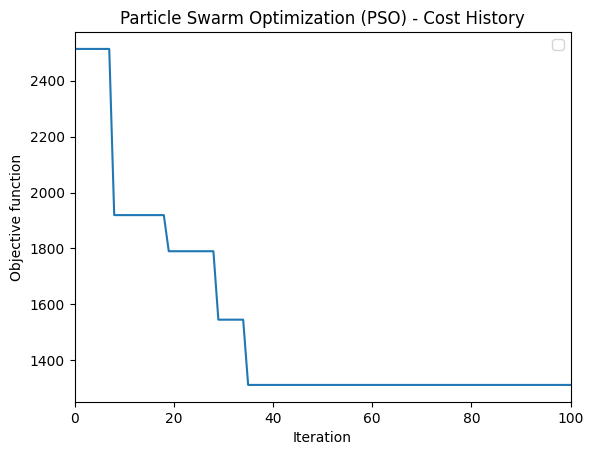

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 1312.5193108689723
Tempo de Convergência para a segunda etapa: 1.1235995292663574 segundos


In [3192]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')


# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

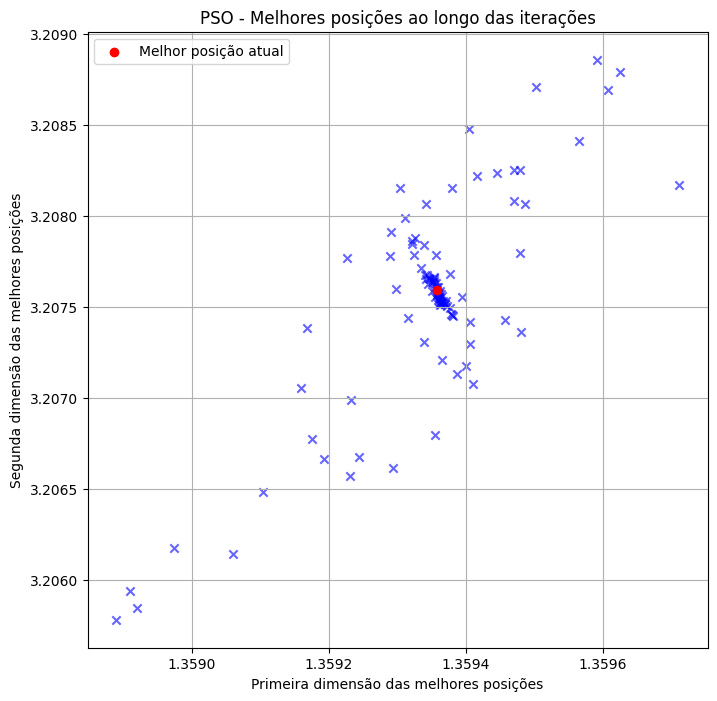

In [3193]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [3228]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [3195]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [3210]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,1324.006652,149.141512,1.002414,0.635381,0.009107,1.109964,8
1,2,1760.275735,149.141512,1.002414,0.635381,0.009803,1.743608,8
2,3,1258.430123,149.141512,1.002414,0.635381,0.010054,1.473404,7
3,4,1160.646611,149.141512,1.002414,0.635381,0.012460,1.429077,6
4,5,1126.239538,149.141512,1.002414,0.635381,0.008656,1.277774,6
5,6,2540.723352,149.141512,1.002414,0.635381,0.006069,1.602389,9
6,7,1335.048024,149.141512,1.002414,0.635381,0.007524,1.437272,7
7,8,1888.983784,149.141512,1.002414,0.635381,0.010195,1.588346,8
8,9,1142.121766,149.141512,1.002414,0.635381,0.011405,1.504158,6
9,10,1312.519311,149.141512,1.002414,0.635381,0.009463,1.123600,6


In [3211]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        10 non-null     int64  
 1   Melhor_Custo                 10 non-null     float64
 2   Lambda                       10 non-null     float64
 3   Beta                         10 non-null     float64
 4   Theta                        10 non-null     float64
 5   Convergencia_Primeira_Etapa  10 non-null     float64
 6   Convergencia_Segunda_Etapa   10 non-null     float64
 7   Ciclos_MP                    10 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 768.0 bytes


In [3212]:
resultado.describe()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000
mean,5.50000,1484.899490,149.141512,1.002414e+00,6.353809e-01,0.009474,1.428959,7.100000
std,3.02765,451.478921,0.000000,2.340556e-16,1.170278e-16,0.001820,0.205492,1.100505
min,1.00000,1126.239538,149.141512,1.002414e+00,6.353809e-01,0.006069,1.109964,6.000000
25%,3.25000,1185.092489,149.141512,1.002414e+00,6.353809e-01,0.008768,1.315600,6.000000
50%,5.50000,1318.262982,149.141512,1.002414e+00,6.353809e-01,0.009633,1.455338,7.000000
75%,7.75000,1653.968807,149.141512,1.002414e+00,6.353809e-01,0.010159,1.567299,8.000000
max,10.00000,2540.723352,149.141512,1.002414e+00,6.353809e-01,0.012460,1.743608,9.000000


In [3213]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

In [ ]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

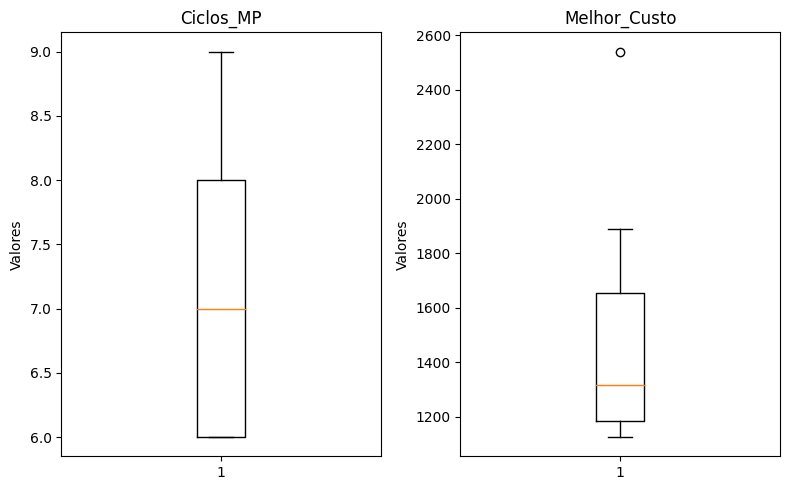

In [3215]:
# Cria uma grafico para os parameros da segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_segunda_etapa):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

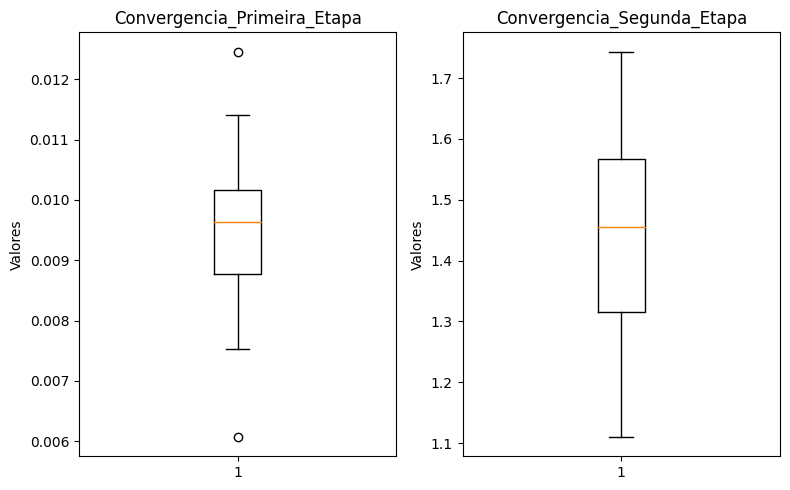

In [3216]:
# Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(convergencia):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [3236]:
# Arrays de tempos e severidade
Tempos = [
    [[0, 22, 74, 175, 247, 313, 426, 534, 640]],
    [[0, 16, 128, 168, 189, 260, 470, 532, 574]],
    [[0, 126, 209, 322, 447, 546, 620, 685]],
    [[0, 9, 179, 208, 365, 549, 621]],
    [[0, 77, 149, 166, 277, 386, 557]],
    [[0, 16, 193, 237, 300, 361, 404, 495, 554, 574]],
    [[0, 46, 79, 169, 304, 487, 642, 675]],
    [[0, 158, 362, 412, 469, 482, 539, 617, 702]],
    [[0, 112, 173, 205, 421, 550, 711]],
    [[0, 63, 185, 370, 593, 622, 647]],
]

severidade = [
    [[0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5]],
    [[0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25]],
    [[0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5]],
    [[0.25, 0.75, 0.25, 0.5, 0.5, 0.25]],
    [[0.5, 0.5, 0.5, 0.5, 0.25, 0.25]],
    [[0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5]],
    [[0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]],
    [[0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5]],
    [[0.25, 0.25, 0.5, 0.25, 0.25, 0.5]],
    [[0.75, 0.75, 0.5, 0.75, 0.5, 0.25]],
]

# # Verifica se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
#         file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [3237]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,"[0, 22, 74, 175, 247, 313, 426, 534, 640]","[0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5]"
1,"[0, 16, 128, 168, 189, 260, 470, 532, 574]","[0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25]"
2,"[0, 126, 209, 322, 447, 546, 620, 685]","[0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5]"
3,"[0, 9, 179, 208, 365, 549, 621]","[0.25, 0.75, 0.25, 0.5, 0.5, 0.25]"
4,"[0, 77, 149, 166, 277, 386, 557]","[0.5, 0.5, 0.5, 0.5, 0.25, 0.25]"
5,"[0, 16, 193, 237, 300, 361, 404, 495, 554, 574]","[0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, ..."
6,"[0, 46, 79, 169, 304, 487, 642, 675]","[0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]"
7,"[0, 158, 362, 412, 469, 482, 539, 617, 702]","[0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5]"
8,"[0, 112, 173, 205, 421, 550, 711]","[0.25, 0.25, 0.5, 0.25, 0.25, 0.5]"
9,"[0, 63, 185, 370, 593, 622, 647]","[0.75, 0.75, 0.5, 0.75, 0.5, 0.25]"


In [3221]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [3222]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,10,10
top,"[0, 352, 417, 534, 592, 642]","[0.5, 0.25, 0.5, 0.5, 0.5]"
freq,1,1
